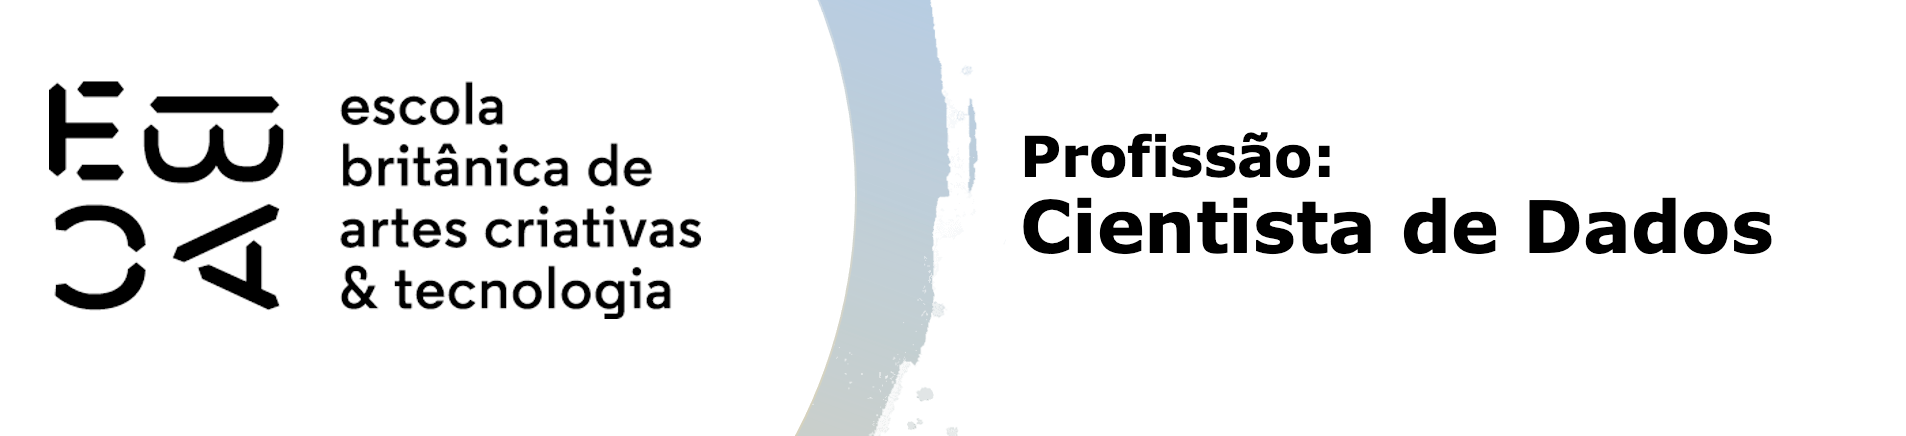

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
!pip install pyarrow

In [2]:
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Criando uma nova coluna no DataFrame que contenha o ano e o mês correspondente de cada data
df['ano_mes'] = df['data_ref'].dt.strftime('%Y-%m')

In [5]:
df['ano_mes'].value_counts().reset_index()

,index,ano_mes
0,2015-01,50000
1,2015-02,50000
2,2015-03,50000
3,2015-04,50000
4,2015-05,50000
5,2015-06,50000
6,2015-07,50000
7,2015-08,50000
8,2015-09,50000
9,2015-10,50000


In [6]:
# Definindo uma lista com os meses para validação (3 últimos do df)
meses_validacao = ['2016-01', '2016-02', '2016-03']

# Criando um DataFrame para os dados de validação
df_valid = df[df['ano_mes'].isin(meses_validacao)]

# Criando um DataFrame para os dados de treinamento (excluindo os meses de validação)
df_treino = df[~df['ano_mes'].isin(meses_validacao)]

In [7]:
df_valid

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,ano_mes
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True,2016-01
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False,2016-01
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False,2016-01
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False,2016-01
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False,2016-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False,2016-03
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False,2016-03
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True,2016-03
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True,2016-03


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [8]:
#criando df de contagem para ver quantas linhas tem em cada mês
contagem_por_mes = df_treino['ano_mes'].value_counts().reset_index()

In [9]:
contagem_por_mes

,index,ano_mes
0,2015-01,50000
1,2015-02,50000
2,2015-03,50000
3,2015-04,50000
4,2015-05,50000
5,2015-06,50000
6,2015-07,50000
7,2015-08,50000
8,2015-09,50000
9,2015-10,50000


In [10]:
#criando df de contagem para ver quantas linhas tem em cada mês
contagem_por_mes_valid = df_valid['ano_mes'].value_counts().reset_index()

In [11]:
contagem_por_mes_valid

,index,ano_mes
0,2016-01,50000
1,2016-02,50000
2,2016-03,50000


In [12]:
df.mau.value_counts()

False    691357
True      58643
Name: mau, dtype: int64

In [13]:
#criando tabela metadados
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['valores_unicos'] = df.nunique()

metadados

,dtype,valores_unicos
data_ref,datetime64[ns],15
index,int64,16650
sexo,object,2
posse_de_veiculo,object,2
posse_de_imovel,object,2
qtd_filhos,int64,8
tipo_renda,object,5
educacao,object,5
estado_civil,object,5
tipo_residencia,object,6


In [14]:
df_treino['mau'] = df_treino['mau'].astype('int64')
df_valid['mau'] = df_valid['mau'].astype('int64')

C:\Users\felip\AppData\Local\Temp\ipykernel_12276\417353658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treino['mau'] = df_treino['mau'].astype('int64')
C:\Users\felip\AppData\Local\Temp\ipykernel_12276\417353658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['mau'] = df_valid['mau'].astype('int64')


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [15]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [16]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'ano_mes'],
      dtype='object')

In [17]:
iv_sexo = IV(df.sexo, df.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.2%


In [18]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0.0,15.0,covariavel
index,int64,0.0,16650.0,covariavel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel


In [19]:
df = df.dropna()
df_treino = df_treino.dropna()
df_valid = df_valid.dropna()

In [20]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0.0,15.0,covariavel
index,int64,0.0,13857.0,covariavel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel


In [21]:
metadados = metadados.drop(['index','bom','data_ref','ano_mes'])

In [22]:
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,46.0,covariavel
tempo_emprego,float64,0.0,3004.0,covariavel


In [23]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.001766
posse_de_veiculo,object,0.0,2.0,covariavel,0.000030
posse_de_imovel,object,0.0,2.0,covariavel,0.011180
qtd_filhos,int64,0.0,8.0,covariavel,0.000105
tipo_renda,object,0.0,5.0,covariavel,0.010465
educacao,object,0.0,5.0,covariavel,0.003511
estado_civil,object,0.0,5.0,covariavel,0.002194
tipo_residencia,object,0.0,6.0,covariavel,0.004111
idade,int64,0.0,46.0,covariavel,0.027295
tempo_emprego,float64,0.0,3004.0,covariavel,0.351920


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [24]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,297638,19868,0.062575,F,317506,0.000430,0.063418,0.061733,-2.706768,-2.692495,-2.721220,0.037068,0.051340,0.022615
M,171322,10297,0.056696,M,181619,0.000543,0.057759,0.055632,-2.811692,-2.791978,-2.831757,-0.067857,-0.048143,-0.087922


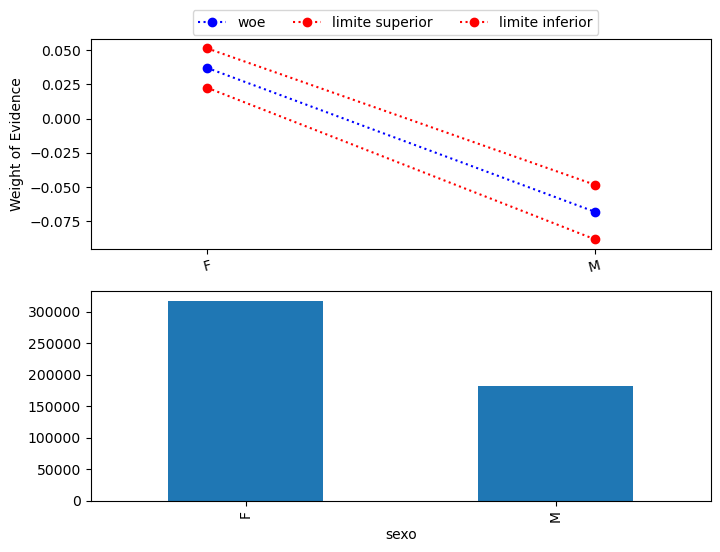

In [25]:
biv_discreta('sexo', df_treino)

In [26]:
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.001766
posse_de_veiculo,object,0.0,2.0,covariavel,0.000030
posse_de_imovel,object,0.0,2.0,covariavel,0.011180
qtd_filhos,int64,0.0,8.0,covariavel,0.000105
tipo_renda,object,0.0,5.0,covariavel,0.010465
educacao,object,0.0,5.0,covariavel,0.003511
estado_civil,object,0.0,5.0,covariavel,0.002194
tipo_residencia,object,0.0,6.0,covariavel,0.004111
idade,int64,0.0,46.0,covariavel,0.027295
tempo_emprego,float64,0.0,3004.0,covariavel,0.351920


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,270777,17507,0.060728,N,288284,0.000445,0.06160,0.059856,-2.738695,-2.723512,-2.754083,0.005140,0.020323,-0.010248
S,198183,12658,0.060036,S,210841,0.000517,0.06105,0.059022,-2.750901,-2.733073,-2.769014,-0.007066,0.010762,-0.025178


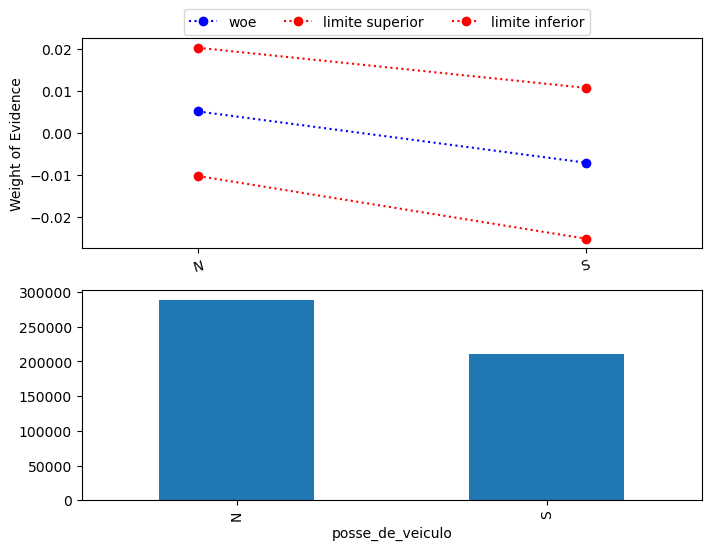

In [27]:
biv_discreta('posse_de_veiculo', df_treino)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,162233,11984,0.068788,N,174217,0.000606,0.069976,0.067599,-2.605461,-2.587054,-2.624165,0.138374,0.156781,0.119670
S,306727,18181,0.055957,S,324908,0.000403,0.056748,0.055167,-2.825581,-2.810719,-2.840642,-0.081746,-0.066884,-0.096807


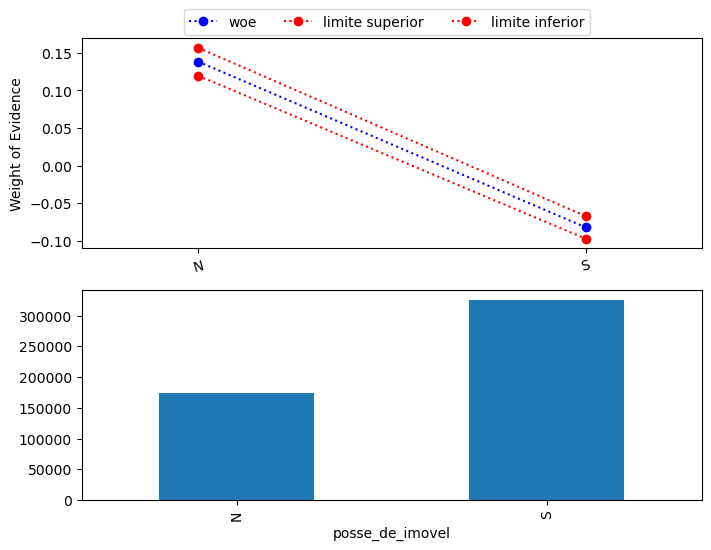

In [28]:
biv_discreta('posse_de_imovel', df_treino)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.053150,0.067528,0.038589
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.402470,0.064077,-1.238781
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.018334,0.003759,-0.040865
Pensionista,230,22,0.087302,Pensionista,252,0.017782,0.122322,0.052281,-2.347037,-1.970623,-2.897422,0.396798,0.773213,-0.153587
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.315315,-0.274534,-0.357669


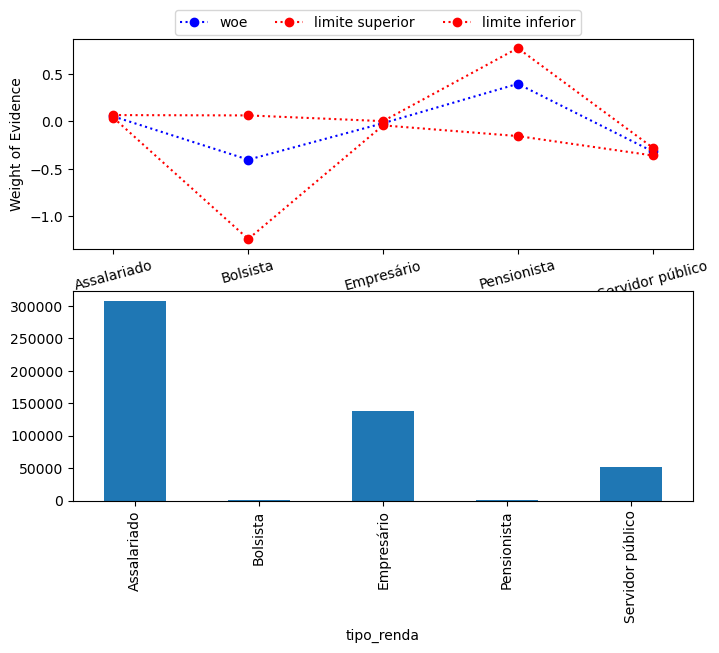

In [29]:
biv_discreta('tipo_renda', df_treino)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,3665,278,0.070505,Fundamental,3943,0.004077,0.078498,0.062512,-2.578963,-2.462938,-2.707848,0.164873,0.280897,0.035987
Médio,305159,20261,0.062261,Médio,325420,0.000424,0.063091,0.061431,-2.712135,-2.698004,-2.726444,0.031700,0.045832,0.017391
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.094860,0.369709,-0.267032
Superior completo,138498,8103,0.055272,Superior completo,146601,0.000597,0.056442,0.054103,-2.838622,-2.816440,-2.861249,-0.094786,-0.072605,-0.117414
Superior incompleto,21030,1480,0.065749,Superior incompleto,22510,0.001652,0.068986,0.062511,-2.653908,-2.602364,-2.707868,0.089927,0.141471,0.035967


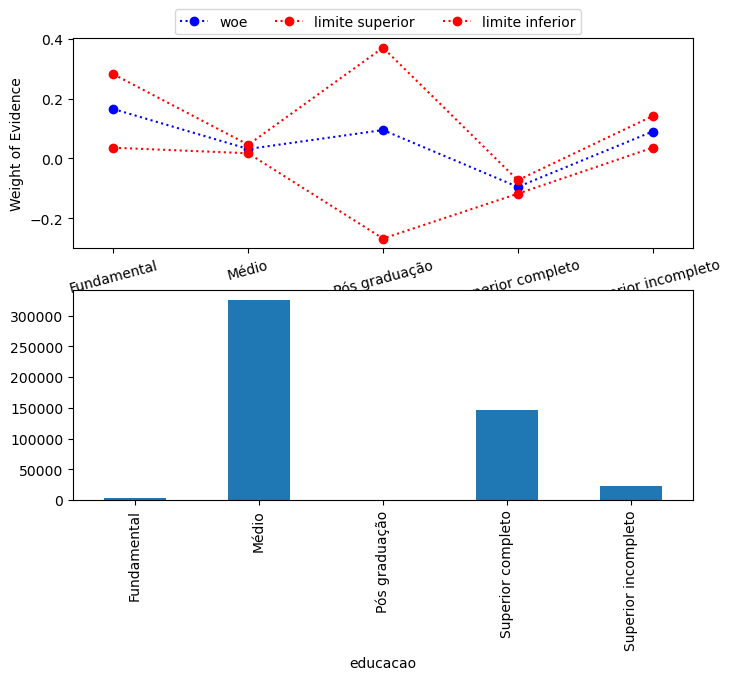

In [30]:
biv_discreta('educacao', df_treino)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,334833,21177,0.059484,Casado,356010,0.000396,0.060261,0.058707,-2.760716,-2.746913,-2.774690,-0.016881,-0.003077,-0.030855
Separado,27293,1813,0.062290,Separado,29106,0.001417,0.065066,0.059513,-2.711647,-2.665071,-2.760204,0.032188,0.078764,-0.016369
Solteiro,58354,3968,0.063669,Solteiro,62322,0.000978,0.065586,0.061752,-2.688266,-2.656552,-2.720882,0.055569,0.087283,0.022953
União,37294,2630,0.065875,União,39924,0.001241,0.068309,0.063442,-2.651849,-2.612967,-2.692089,0.091987,0.130868,0.051746
Viúvo,11186,577,0.049052,Viúvo,11763,0.001991,0.052955,0.045149,-2.964576,-2.883894,-3.051593,-0.220741,-0.140059,-0.307758


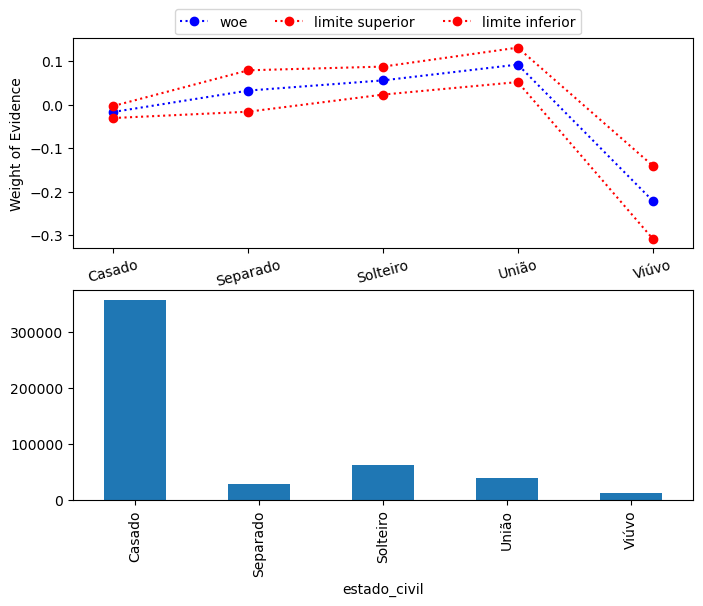

In [31]:
biv_discreta('estado_civil', df_treino)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7183,569,0.073400,Aluguel,7752,0.002962,0.079207,0.067594,-2.535592,-2.453174,-2.624248,0.208243,0.290662,0.119587
Casa,416221,26231,0.059286,Casa,442452,0.000355,0.059981,0.058590,-2.764274,-2.751865,-2.776821,-0.020439,-0.008030,-0.032986
Com os pais,24658,1996,0.074886,Com os pais,26654,0.001612,0.078046,0.071726,-2.513956,-2.469203,-2.560480,0.229879,0.274632,0.183355
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.160756,0.301473,0.000636
Estúdio,3590,200,0.052770,Estúdio,3790,0.003632,0.059891,0.045650,-2.887590,-2.753476,-3.040020,-0.143755,-0.009641,-0.296185
Governamental,14859,984,0.062109,Governamental,15843,0.001918,0.065868,0.058351,-2.714735,-2.651965,-2.781157,0.029100,0.091870,-0.037322


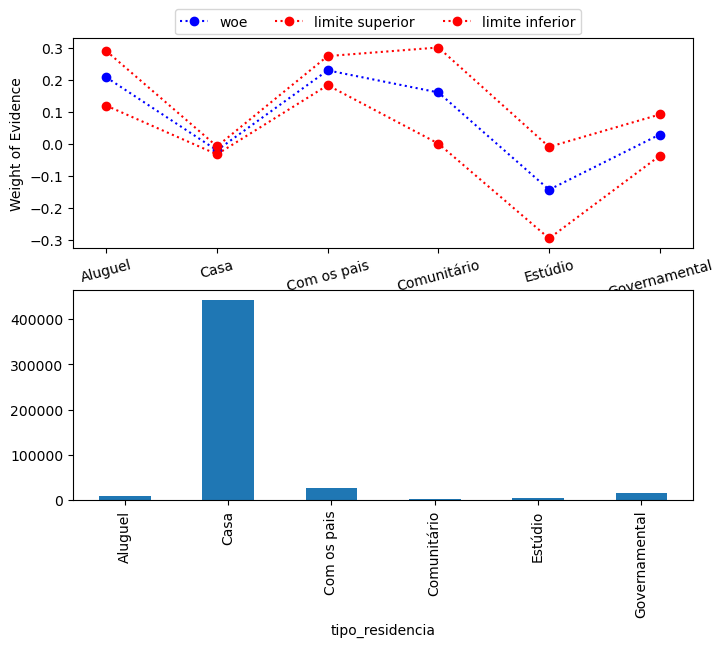

In [32]:
biv_discreta('tipo_residencia', df_treino)

In [33]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

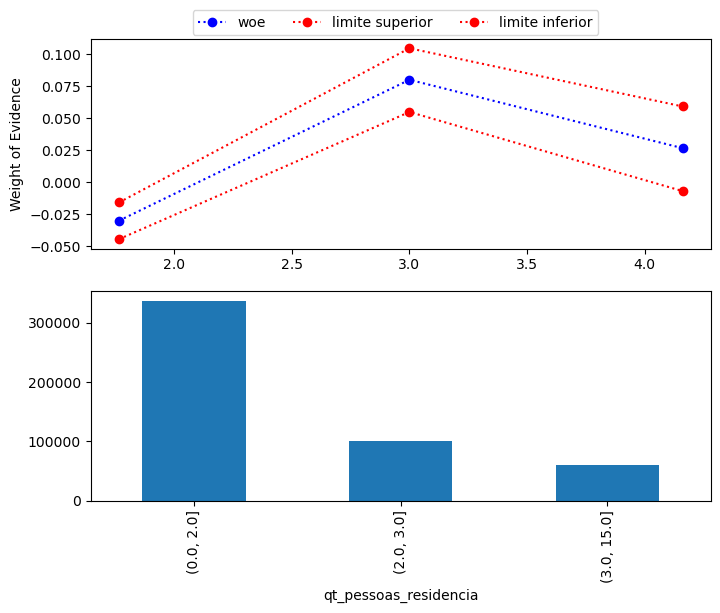

In [34]:
biv_continua('qt_pessoas_residencia',4, df_treino)

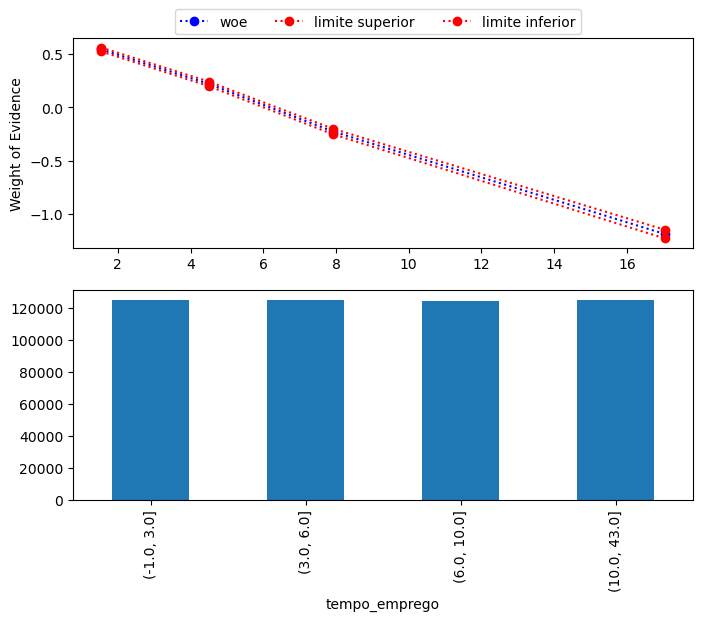

In [35]:
biv_continua('tempo_emprego',4, df_treino)

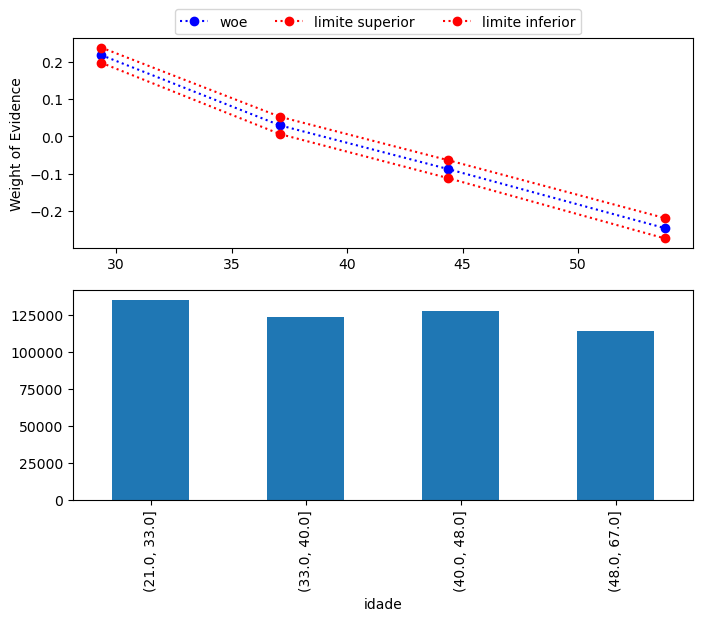

In [36]:
biv_continua('idade',4, df_treino)

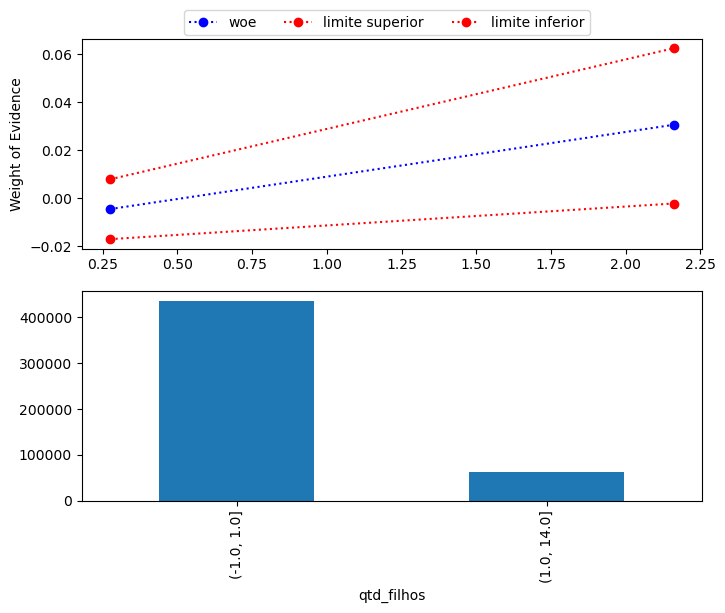

In [37]:
biv_continua('qtd_filhos',4, df_treino)

In [38]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,119214.0,covariavel,1.140500
tempo_emprego,float64,0.0,3004.0,covariavel,0.351920
idade,int64,0.0,46.0,covariavel,0.027295
posse_de_imovel,object,0.0,2.0,covariavel,0.011180
tipo_renda,object,0.0,5.0,covariavel,0.010465
tipo_residencia,object,0.0,6.0,covariavel,0.004111
educacao,object,0.0,5.0,covariavel,0.003511
estado_civil,object,0.0,5.0,covariavel,0.002194
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.002184
sexo,object,0.0,2.0,covariavel,0.001766


In [39]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + idade + posse_de_imovel + tipo_renda + tipo_residencia + educacao + estado_civil + qt_pessoas_residencia + sexo + qtd_filhos + posse_de_veiculo + mau'

In [40]:
formula = '''
    mau ~ renda + tempo_emprego + idade + posse_de_imovel + tipo_renda
'''

rl = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499125
Model:                            GLM   Df Residuals:                   499116
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0255e+05
Date:                Fri, 15 Sep 2023   Deviance:                   2.0498e+05
Time:                        10:18:49   Pearson chi2:                 1.45e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04441
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.5698      0.028    -56.138      0.000      -1.625      -1.515
posse_de_imovel[T.S]              -0.0958      0.013     -7.666      0.000      -0.120      -0.071
tipo_renda[T.Bolsista]             0.0994      0.300      0.332      0.740      -0.488       0.687
tipo_renda[T.Empresário]          -0.0529      0.014     -3.819      0.000      -0.080      -0.026
tipo_renda[T.Pensionista]          0.0123      0.226      0.055      0.956      -0.431       0.455
tipo_renda[T.Servidor público]    -0.0400      0.023     -1.736      0.083      -0.085       0.005
renda                          -9.889e-05   1.17e-06    -84.227      0.000      -0.000   -9.66e-05
tempo_emprego                     -0.0252      0.002    -13.937      0.000      -0.029      -0.022
idade                              0.0009      0.001      1.294      0.196      -0.000       0.002
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [52]:
df_treino['score'] = rl.predict(df_treino)

# Acurácia
acc = metrics.accuracy_score(df_treino.mau, df_treino.score>.090)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_treino.mau, df_treino.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_treino.loc[df_treino.mau == 1, 'score'], df_treino.loc[df_treino.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 71.5% 
AUC: 77.4% 
GINI: 54.9%
KS: 40.7%


In [51]:
df_valid['score'] = rl.predict(df_valid)

# Acurácia
acc = metrics.accuracy_score(df_valid.mau, df_valid.score>.090)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_valid.mau, df_valid.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_valid.loc[df_valid.mau == 1, 'score'], df_valid.loc[df_valid.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 44.5% 
AUC: 73.5% 
GINI: 47.1%
KS: 34.7%


C:\Users\felip\AppData\Local\Temp\ipykernel_12276\238743352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['score'] = rl.predict(df_valid)
